# Imports

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/Users/JordanVani/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Functions

In [45]:
def calc_daily_avg(df, dur="30min"):
    tmp = df[["count"]].copy()
    tmp["d"] = tmp.index.date
    tmp["t"] = map(lambda x: pd.datetime.combine(pd.datetime.today(), x), tmp.index.time)
    tmp = tmp.groupby(["d", "t"]).mean() \
                .unstack(level=0) \
                .resample(dur).mean() \
                .dropna(axis=1).T
    tmp.index = tmp.index.droplevel(0)
    return tmp

def plot_daily_avg(df, dur="30Min", get_results=False, titles=None):
    fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), 
                                   gridspec_kw={"height_ratios": [2, 5]})
    
    df.T.plot(ax=ax1, legend=False, c="k", alpha=0.3, lw=0.8)
    df.mean().T.plot(ax=ax1, c="r", label="Mean")
    ax1.fill_between(df.T.index, 
                     df.mean().T + 2 * df.std().values, 
                     df.mean().T - 2 * df.std().values, 
                     alpha=0.2, color="k", label="2 Std Dev")
    ax1.set_xlabel("Time (H:M)", fontsize=13)
    ax1.set_ylabel("Pedestrian Count", fontsize=13)
    handles, labels = ax1.get_legend_handles_labels()
    handles = handles[-3:]
    ax1.legend(handles, ["Daily Pedestrian Count", "Mean", "2 Std. Dev."])
    ax1.tick_params(axis="both", which="both", labelsize=12)
    
    im = ax2.imshow((df - df.mean()).values, cmap="viridis", aspect="auto")
    cbar = fig.colorbar(im, ax=ax2, orientation="horizontal", pad=0.1)
    cbar.ax.set_xlabel("Pedestrian Count")
    ax2.set_xticklabels(range(24))
    ax2.set_xticks(np.arange(-.5, 47.5, 2))
    ax2.grid(alpha=0.2)
    ax2.set_xlabel("Hour", fontsize=13)
    ax2.set_ylabel("Date", fontsize=13)
    ax2.set_yticks(range(len(df.index)))
    ax2.set_yticklabels(map(lambda x: x[0] + " " + x[1], 
                            zip(map(lambda x: x.strftime("%d-%m-%y"), df.index),
                            map(lambda x: x.strftime("%A")[:3], df.index))))
    ax2.tick_params(axis="x", which="both", labelsize=12)
    
    if titles != None:
        try:
            ax1.set_title(titles[0], fontsize=16)
            ax2.set_title(titles[1], fontsize=16)
        except:
            print "Passed titles are not list-like with len==2"
        
    fig.tight_layout()

# Load Data

In [3]:
df = pd.read_csv("../data/external/hadive-data.csv",
                 usecols=["cam_id", "date", "cam_dir", "count", "imtime"],
                 dtype={"cam_id": int, "date": str, "cam_dir": str, 
                        "count": int, "imtime": str}, parse_dates=["date"], 
                 infer_datetime_format=True, index_col="date")

print df.dtypes
df.head(2)

cam_id      int64
cam_dir    object
count       int64
imtime     object
dtype: object


,cam_id,cam_dir,count,imtime
date,,,,
2017-06-27 20:09:22,368,S,1,NaN
2017-06-27 20:09:23,360,NaN,1,NaN


In [4]:
cams = pd.read_csv("../data/external/cameras.csv")
cams.head(2)

,cam_id,cctv_id,description,lat,long,people,ribbon,boro,zipcode
0,112,83,SIE @ Richmond Ave,40.614885,-74.157435,0.0,1.0,Staten Island,10314
1,121,129,LIE @ Kissena Blvd,40.738943,-73.815047,1.0,0.0,Queens,11367


In [5]:
df = df.reset_index().merge(cams).set_index("date")[["cam_id", "count", "people", "boro"]]
df.head(2)

,cam_id,count,people,boro
date,,,,
2017-06-27 20:09:22,368,1,1.0,Manhattan
2017-06-27 20:10:39,368,1,1.0,Manhattan


# Anomaly Plots
## Choose a Camera

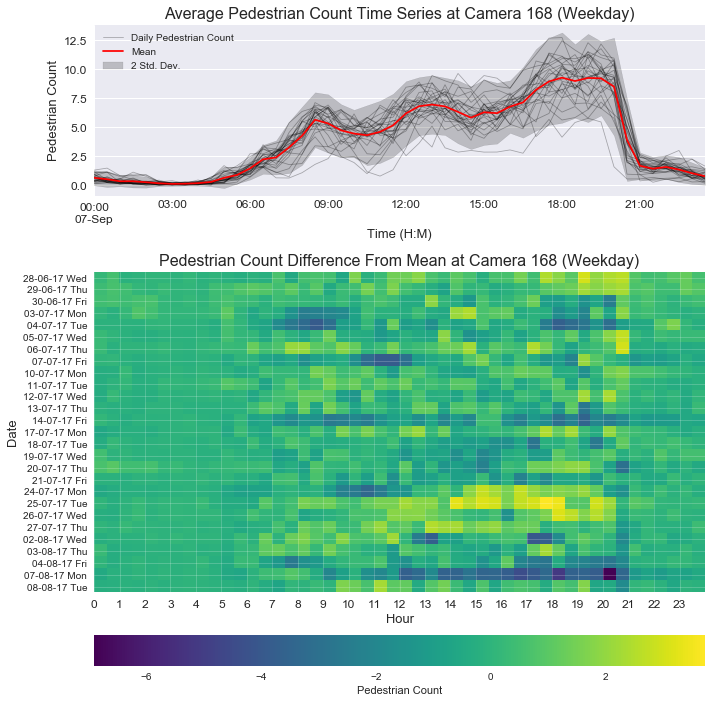

In [107]:
tmp = calc_daily_avg(df[(df.cam_id == 168) & 
                        (df.index.weekday < 5) &
                        (df.index < pd.datetime(2017, 8, 9))])
plot_daily_avg(
    tmp,
    titles=("Average Pedestrian Count Time Series at Camera 168 (Weekday)",
            "Pedestrian Count Difference From Mean at Camera 168 (Weekday)"))

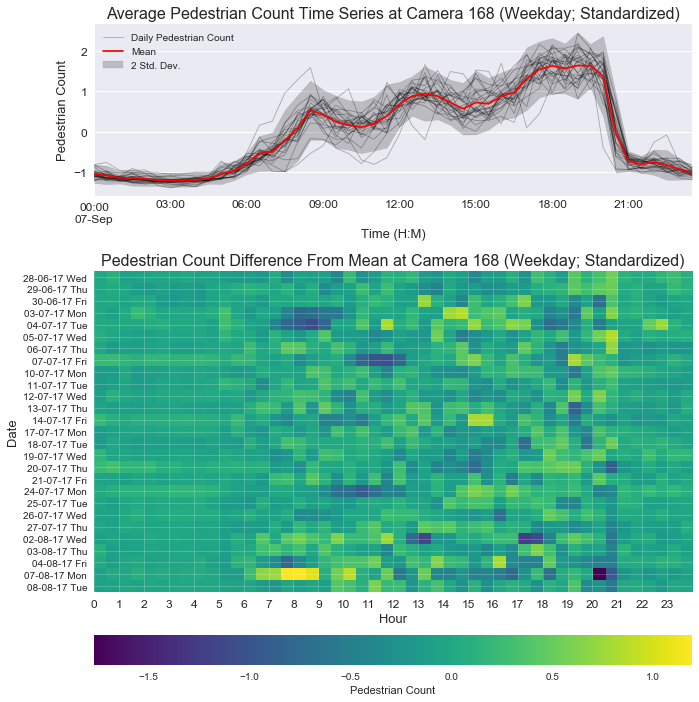

In [108]:
plot_daily_avg(
    tmp.T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    titles=("Average Pedestrian Count Time Series at Camera 168 (Weekday; Standardized)",
            "Pedestrian Count Difference From Mean at Camera 168 (Weekday; Standardized)"))

## Manhattan
### Weekday

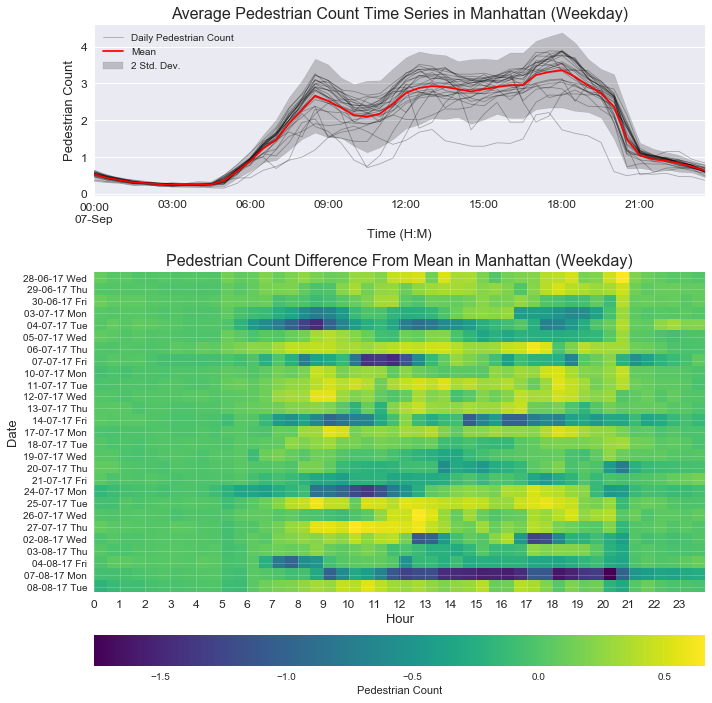

In [95]:
tmp = calc_daily_avg(df[(df.boro == "Manhattan") & 
                        (df.people == 1.) & 
                        (df.index.weekday < 5) &
                        (df.index < pd.datetime(2017, 8, 9))])

plot_daily_avg(
    tmp,
    titles=("Average Pedestrian Count Time Series in Manhattan (Weekday)",
            "Pedestrian Count Difference From Mean in Manhattan (Weekday)"))

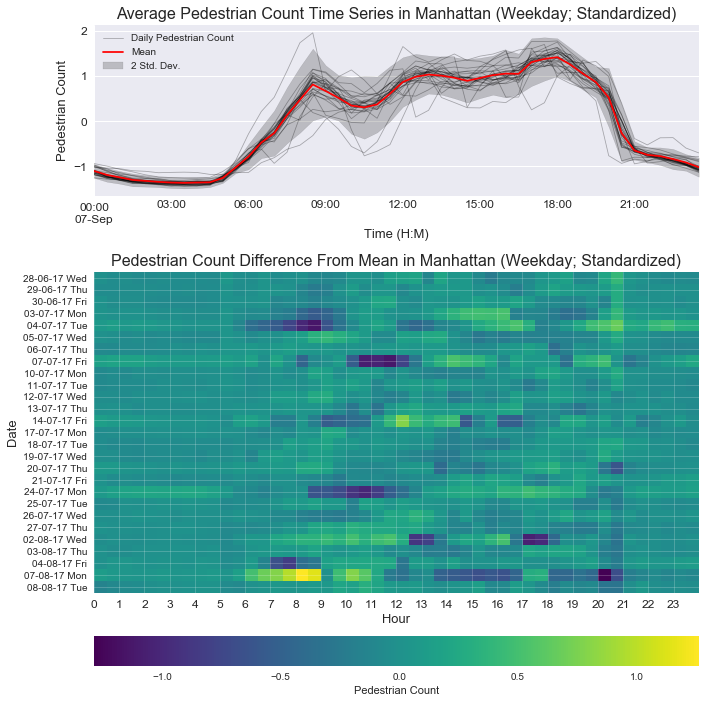

In [106]:
plot_daily_avg(
    tmp.T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    titles=("Average Pedestrian Count Time Series in Manhattan (Weekday; Standardized)",
            "Pedestrian Count Difference From Mean in Manhattan (Weekday; Standardized)"))

### Weekend

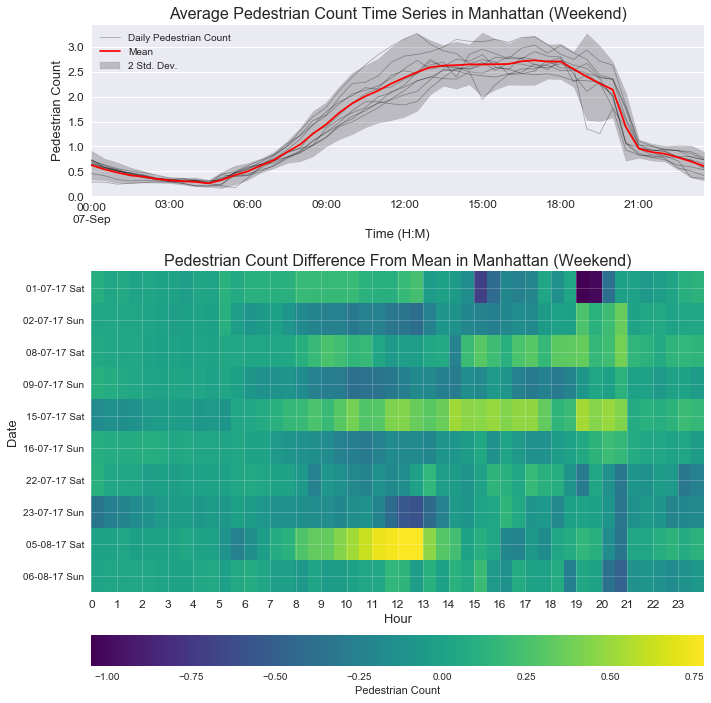

In [109]:
tmp = calc_daily_avg(df[(df.boro == "Manhattan") & 
                        (df.people == 1.) & 
                        (df.index.weekday >= 5) &
                        (df.index < pd.datetime(2017, 8, 9))])

plot_daily_avg(
    tmp,
    titles=("Average Pedestrian Count Time Series in Manhattan (Weekend)",
            "Pedestrian Count Difference From Mean in Manhattan (Weekend)"))

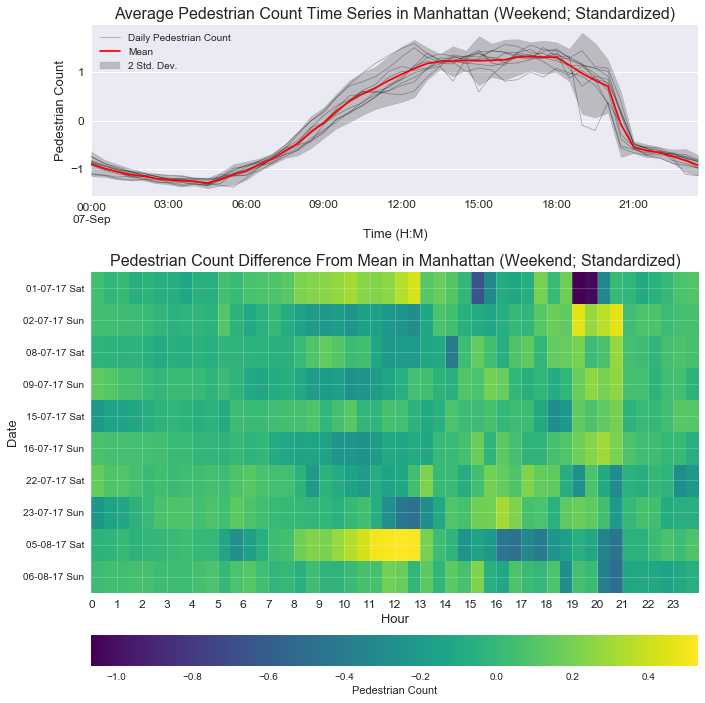

In [110]:
plot_daily_avg(
    tmp.T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    titles=("Average Pedestrian Count Time Series in Manhattan (Weekend; Standardized)",
            "Pedestrian Count Difference From Mean in Manhattan (Weekend; Standardized)"))

## Brooklyn
### Weekday

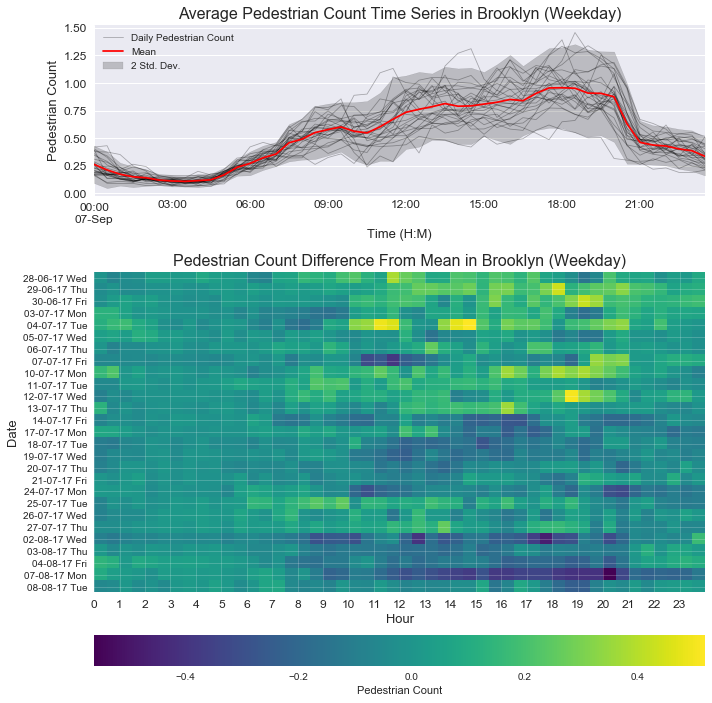

In [111]:
tmp = calc_daily_avg(df[(df.boro == "Brooklyn") & 
                        (df.people == 1.) & 
                        (df.index.weekday < 5) &
                        (df.index < pd.datetime(2017, 8, 9))])

plot_daily_avg(
    tmp,
    titles=("Average Pedestrian Count Time Series in Brooklyn (Weekday)",
            "Pedestrian Count Difference From Mean in Brooklyn (Weekday)"))

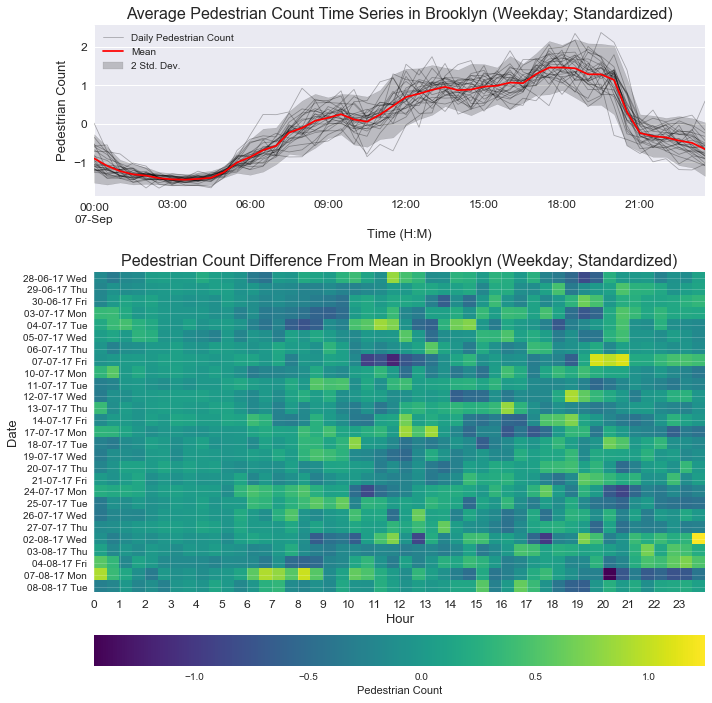

In [112]:
plot_daily_avg(
    tmp.T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    titles=("Average Pedestrian Count Time Series in Brooklyn (Weekday; Standardized)",
            "Pedestrian Count Difference From Mean in Brooklyn (Weekday; Standardized)"))

### Weekend

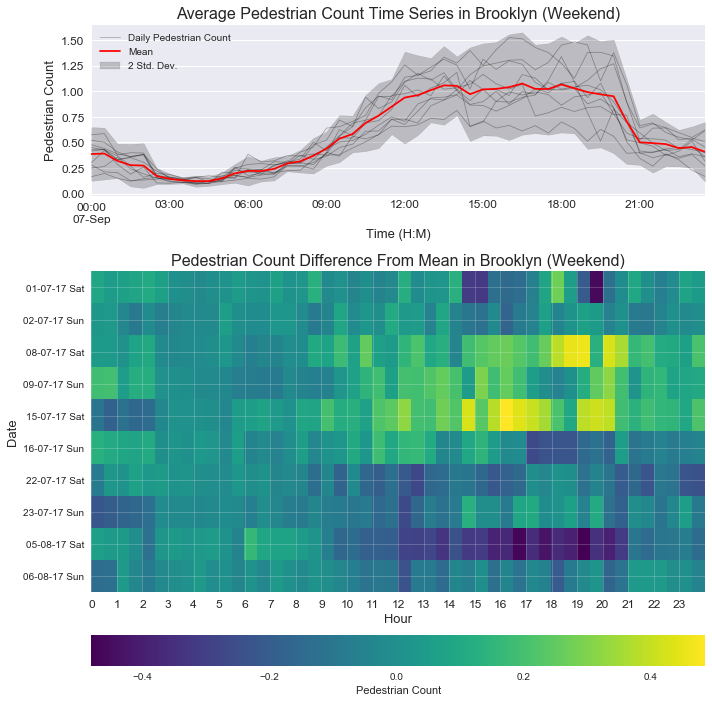

In [113]:
tmp = calc_daily_avg(df[(df.boro == "Brooklyn") & 
                        (df.people == 1.) & 
                        (df.index.weekday >= 5) &
                        (df.index < pd.datetime(2017, 8, 9))])

plot_daily_avg(
    tmp,
    titles=("Average Pedestrian Count Time Series in Brooklyn (Weekend)",
            "Pedestrian Count Difference From Mean in Brooklyn (Weekend)"))

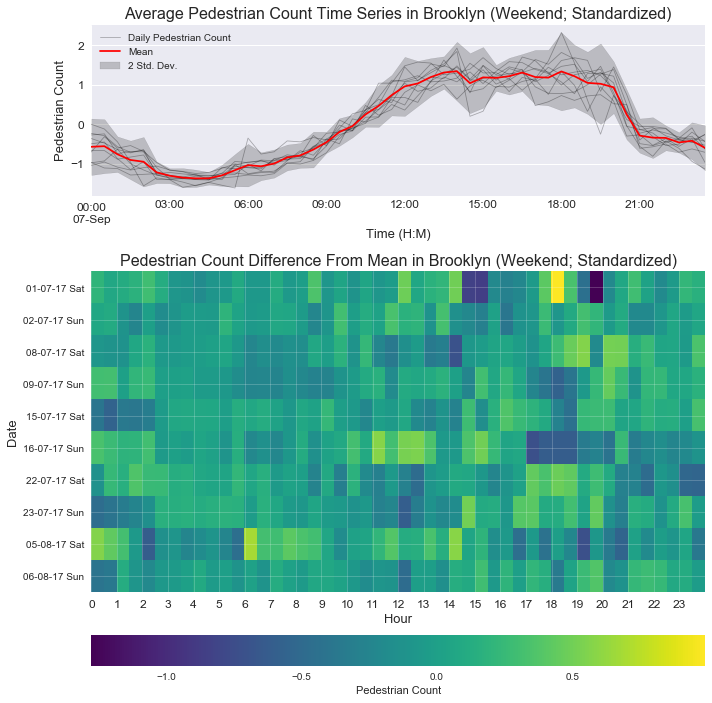

In [114]:
plot_daily_avg(
    tmp.T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    titles=("Average Pedestrian Count Time Series in Brooklyn (Weekend; Standardized)",
            "Pedestrian Count Difference From Mean in Brooklyn (Weekend; Standardized)"))

## Bronx
### Weekday

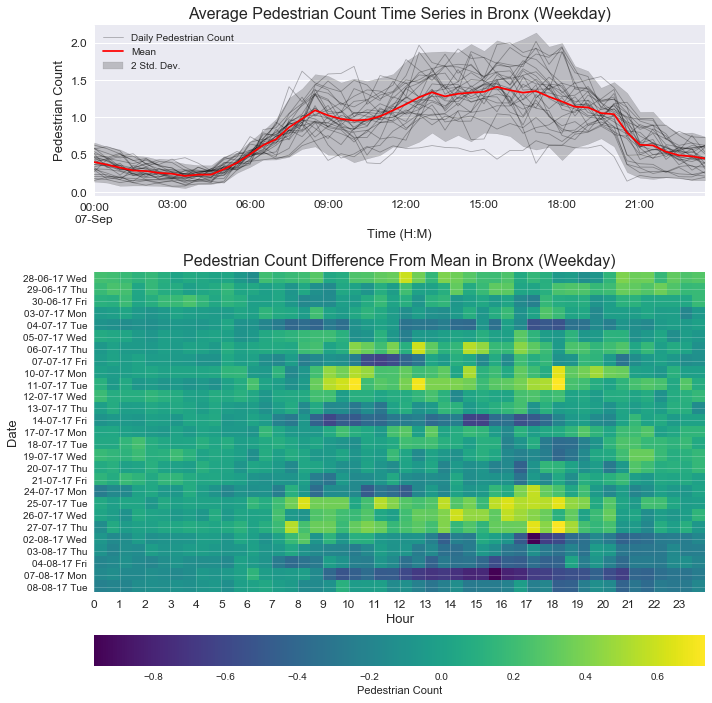

In [115]:
tmp = calc_daily_avg(df[(df.boro == "Bronx") & 
                        (df.people == 1.) & 
                        (df.index.weekday < 5) &
                        (df.index < pd.datetime(2017, 8, 9))])

plot_daily_avg(
    tmp,
    titles=("Average Pedestrian Count Time Series in Bronx (Weekday)",
            "Pedestrian Count Difference From Mean in Bronx (Weekday)"))

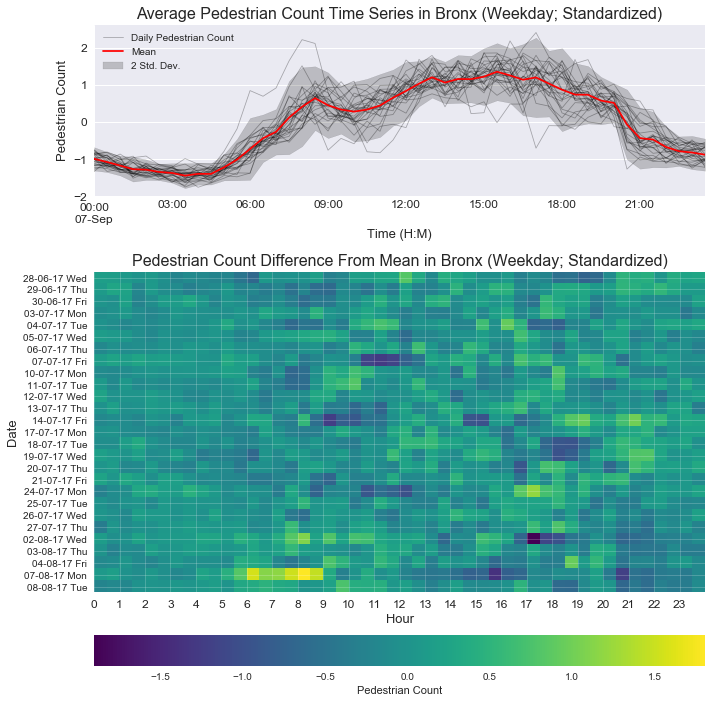

In [116]:
plot_daily_avg(
    tmp.T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    titles=("Average Pedestrian Count Time Series in Bronx (Weekday; Standardized)",
            "Pedestrian Count Difference From Mean in Bronx (Weekday; Standardized)"))

### Weekend

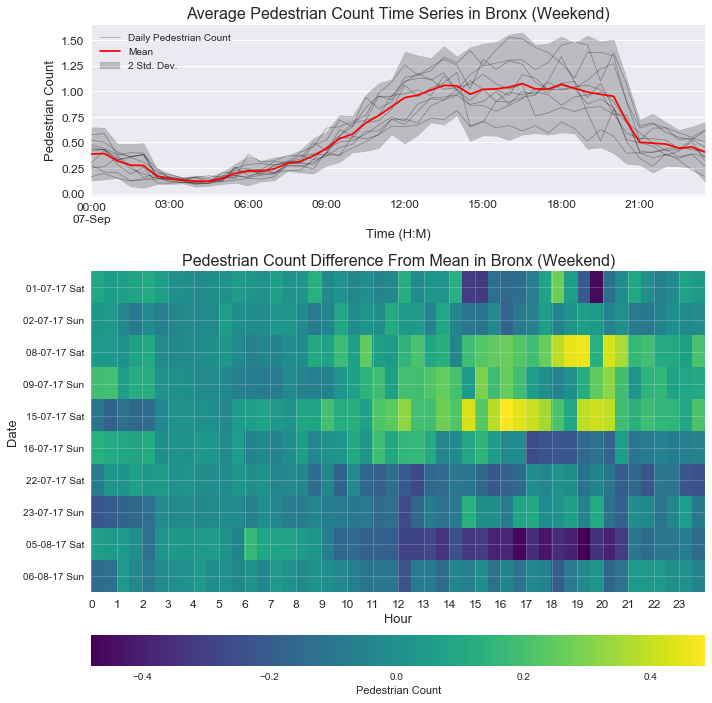

In [117]:
tmp = calc_daily_avg(df[(df.boro == "Brooklyn") & 
                        (df.people == 1.) & 
                        (df.index.weekday >= 5) &
                        (df.index < pd.datetime(2017, 8, 9))])

plot_daily_avg(
    tmp,
    titles=("Average Pedestrian Count Time Series in Bronx (Weekend)",
            "Pedestrian Count Difference From Mean in Bronx (Weekend)"))

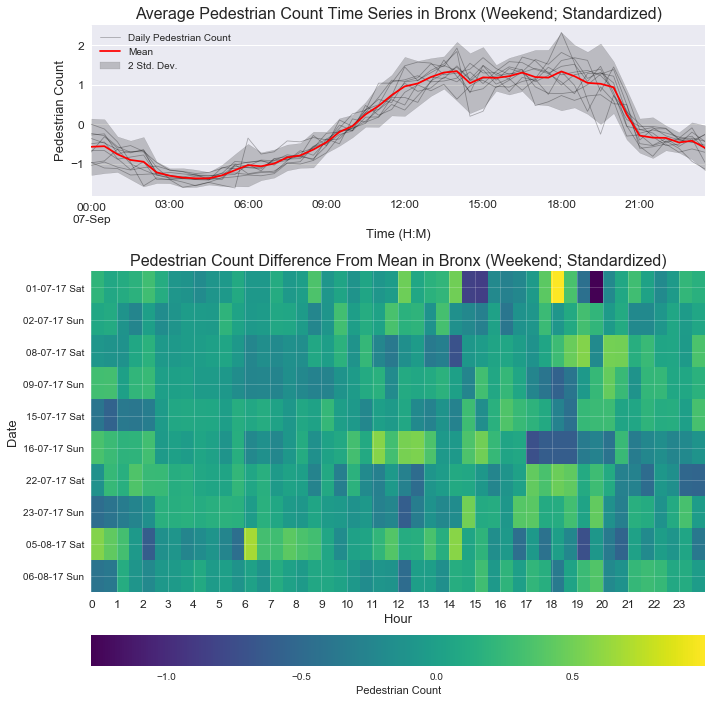

In [118]:
plot_daily_avg(
    tmp.T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    titles=("Average Pedestrian Count Time Series in Bronx (Weekend; Standardized)",
            "Pedestrian Count Difference From Mean in Bronx (Weekend; Standardized)"))

## Queens
### Weekday

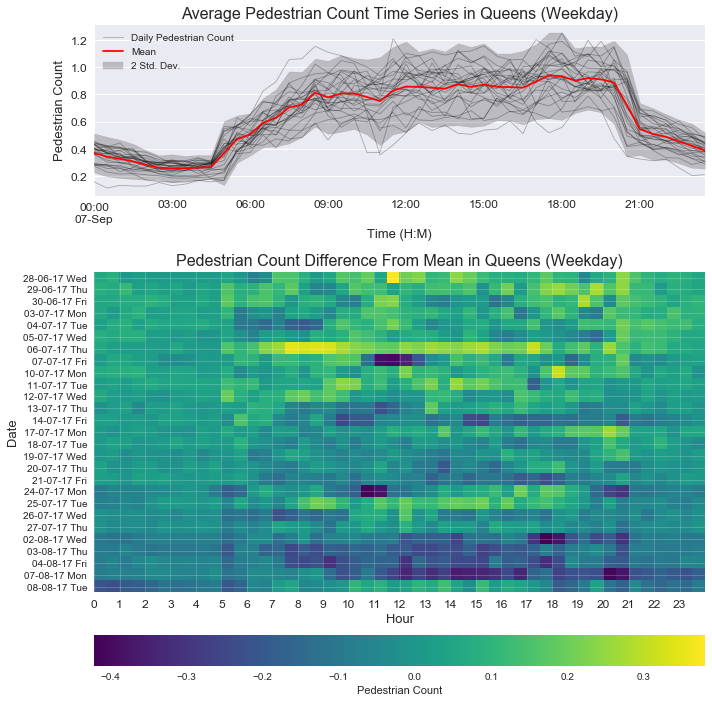

In [119]:
tmp = calc_daily_avg(df[(df.boro == "Queens") & 
                        (df.people == 1.) & 
                        (df.index.weekday < 5) &
                        (df.index < pd.datetime(2017, 8, 9))])

plot_daily_avg(
    tmp,
    titles=("Average Pedestrian Count Time Series in Queens (Weekday)",
            "Pedestrian Count Difference From Mean in Queens (Weekday)"))

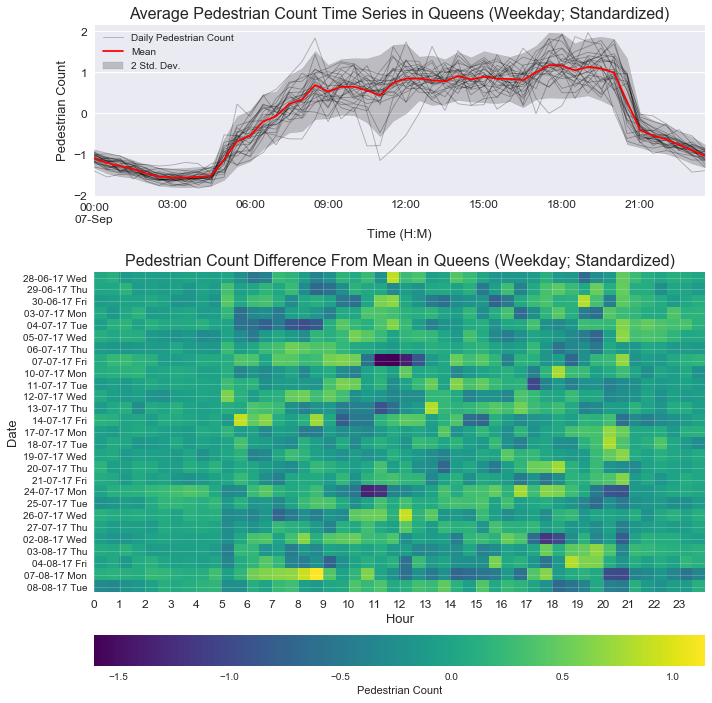

In [120]:
plot_daily_avg(
    tmp.T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    titles=("Average Pedestrian Count Time Series in Queens (Weekday; Standardized)",
            "Pedestrian Count Difference From Mean in Queens (Weekday; Standardized)"))

### Weekend

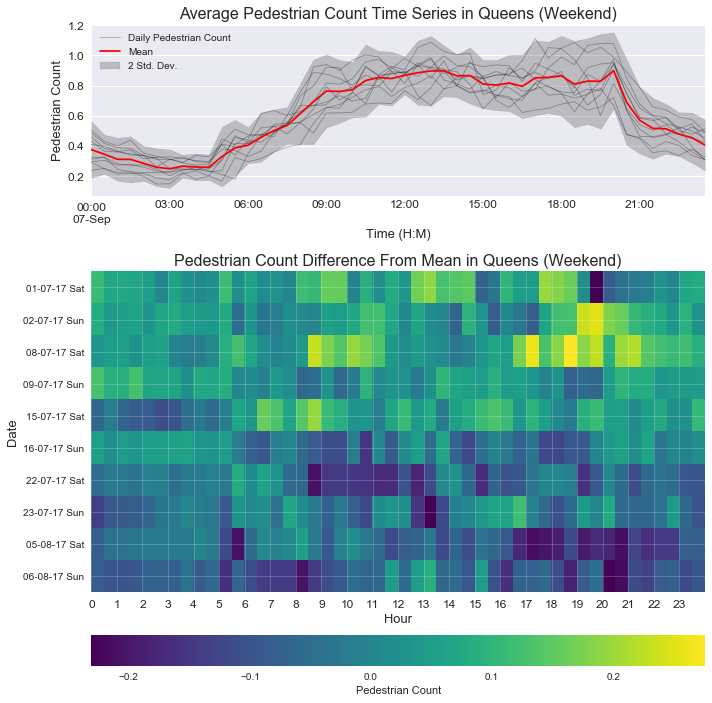

In [121]:
tmp = calc_daily_avg(df[(df.boro == "Queens") & 
                        (df.people == 1.) & 
                        (df.index.weekday >= 5) &
                        (df.index < pd.datetime(2017, 8, 9))])

plot_daily_avg(
    tmp,
    titles=("Average Pedestrian Count Time Series in Queens (Weekend)",
            "Pedestrian Count Difference From Mean in Queens (Weekend)"))

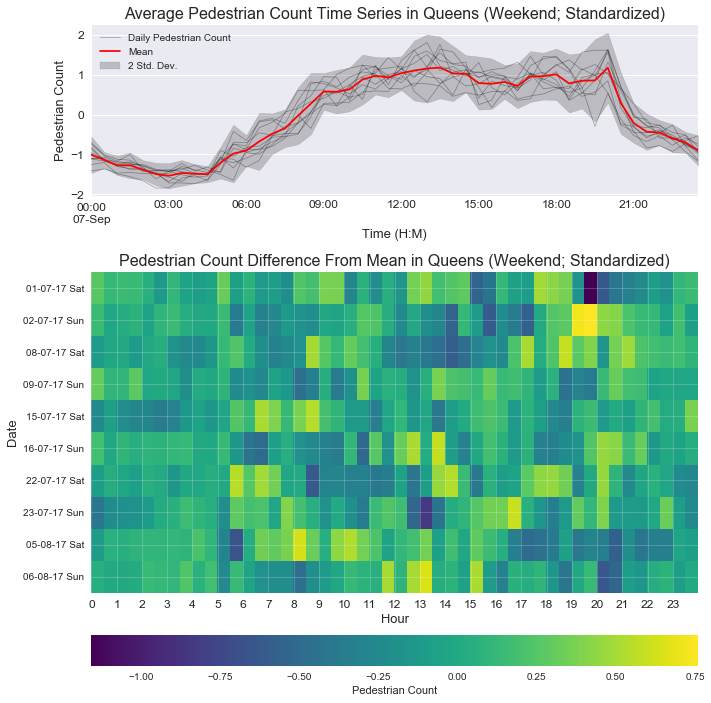

In [122]:
plot_daily_avg(
    tmp.T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    titles=("Average Pedestrian Count Time Series in Queens (Weekend; Standardized)",
            "Pedestrian Count Difference From Mean in Queens (Weekend; Standardized)"))

## Staten Island
### Weekday

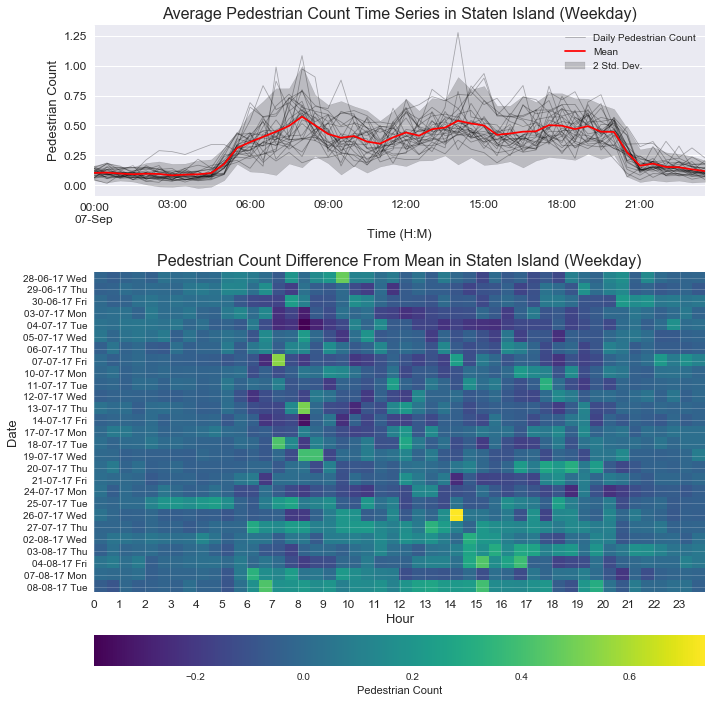

In [123]:
tmp = calc_daily_avg(df[(df.boro == "Staten Island") & 
                        (df.people == 1.) & 
                        (df.index.weekday < 5) &
                        (df.index < pd.datetime(2017, 8, 9))])

plot_daily_avg(
    tmp,
    titles=("Average Pedestrian Count Time Series in Staten Island (Weekday)",
            "Pedestrian Count Difference From Mean in Staten Island (Weekday)"))

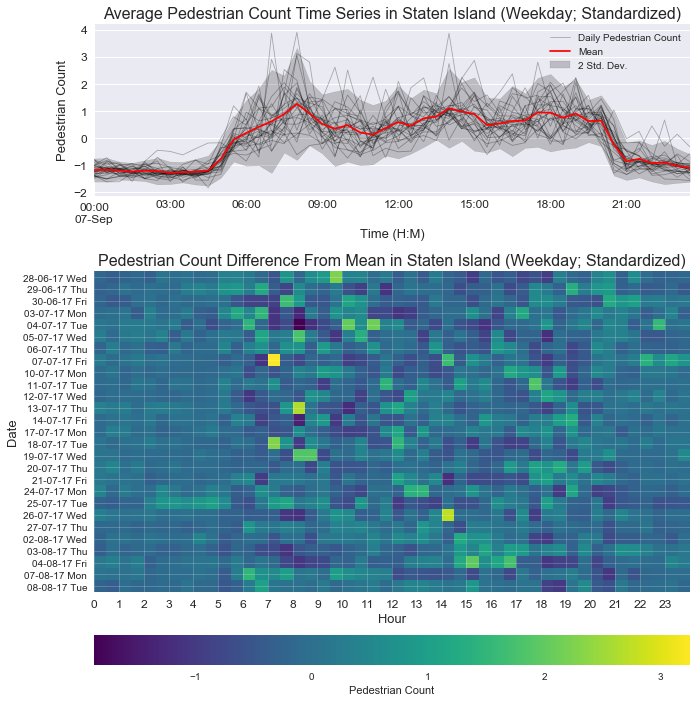

In [124]:
plot_daily_avg(
    tmp.T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    titles=("Average Pedestrian Count Time Series in Staten Island (Weekday; Standardized)",
            "Pedestrian Count Difference From Mean in Staten Island (Weekday; Standardized)"))

### Weekend

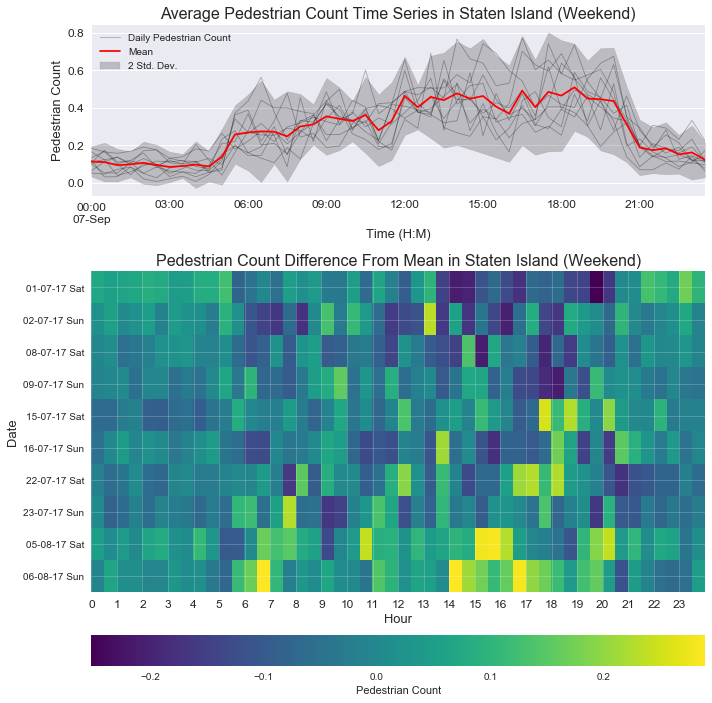

In [125]:
tmp = calc_daily_avg(df[(df.boro == "Staten Island") & 
                        (df.people == 1.) & 
                        (df.index.weekday >= 5) &
                        (df.index < pd.datetime(2017, 8, 9))])

plot_daily_avg(
    tmp,
    titles=("Average Pedestrian Count Time Series in Staten Island (Weekend)",
            "Pedestrian Count Difference From Mean in Staten Island (Weekend)"))

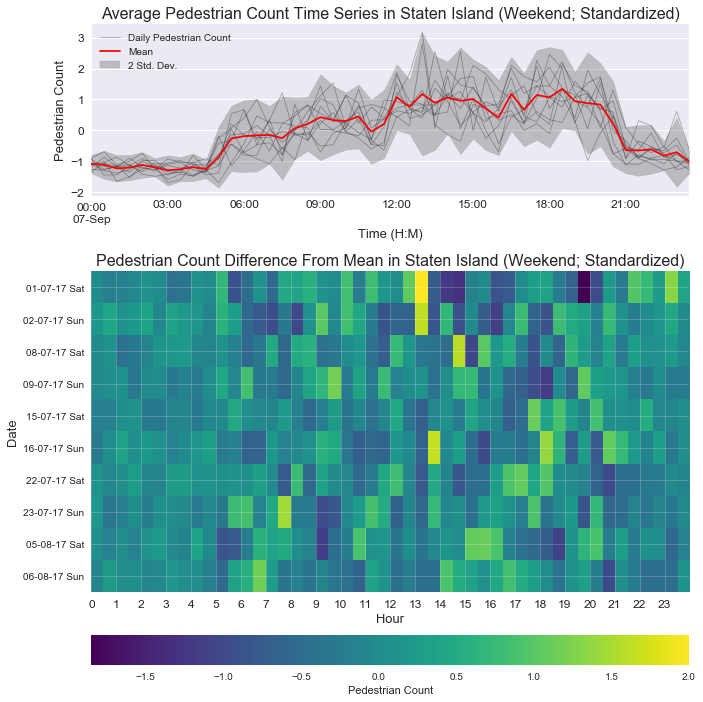

In [126]:
plot_daily_avg(
    tmp.T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    titles=("Average Pedestrian Count Time Series in Staten Island (Weekend; Standardized)",
            "Pedestrian Count Difference From Mean in Staten Island (Weekend; Standardized)"))